# Exercise 7

Perform cluster analysis on DJIA Index components using K-Means and build an equal weight portfolio from the selected stocks. Retrieve the list of DJIA components; identify and clean any missing data points. Cluster stocks based on weekly ATR and compare it with the original dataset.

## Solutions

### K-Means Clustering

Clustering is a branch of unsupervised machine learning models that seeks to learn from the properties of the data by identifying groups or clusters in the dataset.

The 𝑘-means algorithm searches for a predetermined number of clusters within an unlabeled dataset and is based on the assumptions that the optimal cluster will have cluster center and each point is closer to its own cluster center than to other cluster centers.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Libraries 
import pandas as pd
import numpy as np 
import pyfolio as pf

from kneed import KneeLocator 
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the pre-saved data dict 
ohlc = np.load('dow_ohlc.npy', allow_pickle='TRUE').item()   # data is saved in pickle format to save space
# ohlc is a dictionary, each key is a tick-mark, the corresponding item is the price performance
ohlc['MMM'].head()

,Open,High,Low,Close,Volume
Date,,,,,
2009-12-31,62.906018,63.123738,61.967570,62.065166,2049800
2010-01-04,62.380479,62.650753,62.065162,62.327927,3043700
2010-01-05,62.162779,62.485606,61.336941,61.937550,2847000
2010-01-06,62.973588,63.514135,62.695811,62.815929,5268500
2010-01-07,62.553137,62.883472,61.652230,62.860950,4470100


In [3]:
ohlc.keys()

dict_keys(['VZ', 'WMT', 'V', 'MRK', 'GS', 'DOW', 'PG', 'JNJ', 'JPM', 'IBM', 'AXP', 'KO', 'CVX', 'WBA', 'TRV', 'MSFT', 'AAPL', 'DIS', 'MCD', 'CAT', 'NKE', 'AMGN', 'HD', 'CSCO', 'HON', 'INTC', 'MMM', 'BA', 'UNH', 'CRM'])

In [4]:
# List of DJIA stocks (Dow Jones Industrial Average)
dow_stocks = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
              'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT',
              'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS']

In [5]:
# Function to calculate average true range 
def ATR(df,n):
    
    '''function to calculate Average True Range'''
    
    df = df.copy()

    df['H-L'] = abs(df['High']-df['Low']) 
    df['H-PC'] = abs(df['High']-df['Close'].shift(1)) 
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))

    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False) # the max among H-L, H-PC, and L-PC
    df['ATR'] = df['TR'].rolling(n).mean()
    
    return df['ATR']

In [6]:
# Add ATR for each stocks 
for symbol in dow_stocks:
    ohlc[symbol]['ATR'] = ATR(ohlc[symbol],21)

In [7]:
# Subsume into dataframe 
df = pd.DataFrame({symbol: ohlc[symbol]['ATR'] for symbol in dow_stocks})

print('Those nan are mostly from the rolling window')

# Check for missing values 
df.isnull().sum()

Those nan are mostly from the rolling window


MMM       22
AXP       22
AMGN      22
AAPL      22
BA        22
CAT       43
CVX       22
CSCO      22
KO        22
DOW     2340
GS        22
HD        22
HON       22
IBM       22
INTC      22
JNJ       22
JPM       22
MCD       22
MRK       22
MSFT      22
NKE       22
PG        22
CRM       22
TRV       22
UNH       22
VZ        22
V         22
WBA       22
WMT       22
DIS       22
dtype: int64

In [8]:
# Fill forward the missing values and drop DOW company from the list 
df.fillna(method='bfill', axis=0, inplace=True)
df.drop(['DOW'], axis=1, inplace=True)

In [9]:
# Resample to a weekly timeframe for cluster analysis 
px = df.resample('W-FRI').mean() # resample to be weekly
px = px.T

# Check output 
px

Date,2010-01-01,2010-01-08,2010-01-15,2010-01-22,2010-01-29,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,...,2020-07-31,2020-08-07,2020-08-14,2020-08-21,2020-08-28,2020-09-04,2020-09-11,2020-09-18,2020-09-25,2020-10-02
MMM,1.113625,1.113625,1.113625,1.113625,1.113625,1.153880,1.233820,1.308653,1.232967,1.071002,...,3.304308,3.337810,3.339979,3.176965,2.863492,2.869821,3.166674,3.413893,4.169714,4.322380
AXP,1.035185,1.035185,1.035185,1.035185,1.035185,1.046649,1.079262,1.101860,0.908801,0.774188,...,2.843043,2.639048,2.661429,2.715334,2.638858,2.682953,2.666072,2.634953,3.009524,3.067619
AMGN,0.944033,0.944033,0.944033,0.944033,0.944033,0.935090,0.901456,0.842463,0.764781,0.697285,...,6.991551,5.912776,5.513730,5.206030,5.178612,5.526902,6.276775,6.502001,7.032953,6.745236
AAPL,0.189773,0.189773,0.189773,0.189773,0.189773,0.194869,0.202438,0.196099,0.168340,0.132842,...,2.461490,3.033089,3.262488,3.310282,3.489328,3.854957,5.046608,5.506762,5.922024,6.040714
BA,1.420966,1.420966,1.420966,1.420966,1.420966,1.395097,1.348466,1.392967,1.330655,1.184213,...,8.306858,7.601714,7.459999,7.183617,7.058093,6.733713,6.922977,6.694763,7.148001,7.457144
CAT,1.533670,1.533670,1.533670,1.533670,1.533670,1.520942,1.573473,1.557398,1.375859,1.202488,...,3.214466,3.226924,3.256621,3.086761,3.204095,3.154476,3.518809,3.867809,4.522095,4.661904
CVX,0.948067,0.948067,0.948067,0.948067,0.948067,0.954870,1.043509,1.090255,1.021200,0.923124,...,2.715329,2.679841,2.612996,2.404789,2.250110,1.998820,2.083493,2.094879,2.283048,2.434763
CSCO,0.455210,0.455210,0.455210,0.455210,0.455210,0.451763,0.459877,0.427567,0.373286,0.320226,...,0.946124,0.948584,1.014642,1.103441,0.996145,0.926313,0.959130,0.707852,0.772871,0.819819
KO,0.292113,0.292113,0.292113,0.292113,0.292113,0.299016,0.322607,0.325995,0.317540,0.330460,...,0.943505,0.967596,0.901276,0.806897,0.759754,0.817288,0.953826,0.979944,1.113322,1.164498
GS,4.401394,4.401394,4.401394,4.401394,4.401394,4.418970,4.474883,4.346649,3.533104,3.016992,...,6.037351,5.294707,4.534830,4.198391,4.267118,4.513423,5.035561,4.921476,5.582563,5.937155


### Elbow Plot

The number of clusters is a hyperparameter to clustering models and choose the optimal number of clusters is critical for the model. We identify the elbow point programmatically for this exercise.

The **Knee** seems a point of $k$ at which the KNN makes huge improvement.

In [10]:
# run KNN based on the ATR of 30 stocks (29) in the Dow Jones Industrial Index
# choose/tune the hyper-parameter k

scaler = MinMaxScaler() 
scaled_px = scaler.fit_transform(px) 

In [11]:
# Get the inertia 
sse = [] 

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(scaled_px) 
    sse.append(kmeans.inertia_)

# Knee Locator, # KneeLocator is a sub-class from knee
kl = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing") 
kl.elbow

7

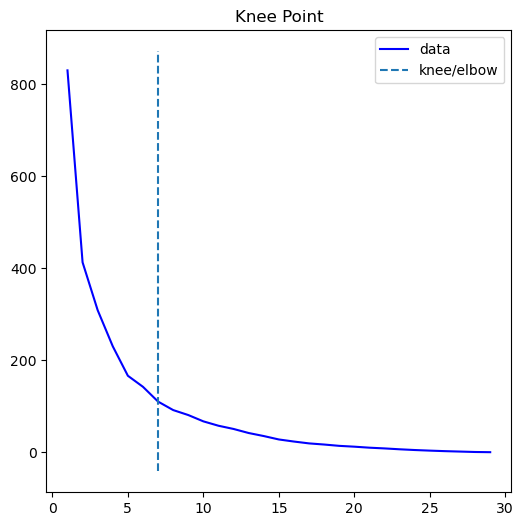

In [12]:
# Raw data and knee. 
kl.plot_knee()

Text(0.5, 1.0, 'Knee Point')

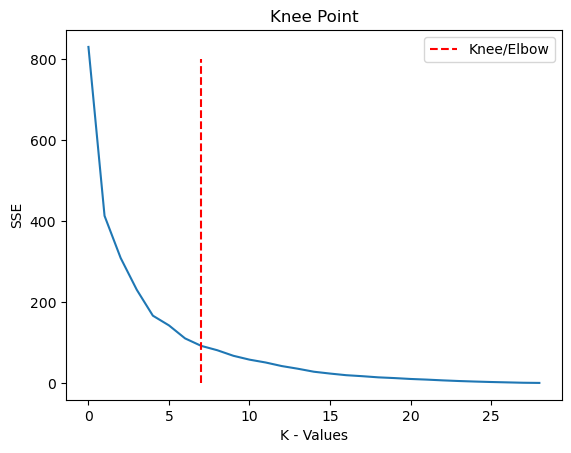

In [13]:
plt.plot(sse)
plt.vlines(x=kl.elbow, ymin=0, ymax=800, color='red', linestyles='dashed', label='Knee/Elbow')
plt.ylabel('SSE')
plt.xlabel('K - Values')
plt.legend()
plt.title('Knee Point')

### Build Clusters

We will now fit the cluster model.

In [14]:
# Build clusters 
model = KMeans(n_clusters=6) # 6 is selected from the elbow
model.fit(scaled_px)

labels = model.predict(scaled_px) 
labels

array([0, 2, 4, 1, 5, 0, 0, 1, 1, 3, 2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 1, 0,
       2, 5, 1, 2, 2, 2, 2], dtype=int32)

In [15]:
# Remove DOW from the list 
companies = dow_stocks

companies.remove('DOW')

In [16]:
df1 = pd.DataFrame({'Cluster': labels,
                    'Companies': companies, # let the ATR value be the 10-year mean of each company
                    'ATR': px.mean(axis=1), }).sort_values(by=['Cluster'], axis = 0)

df1 = df1.reset_index(drop=True) 
df1

,Cluster,Companies,ATR
0,0,MMM,2.101291
1,0,IBM,2.095919
2,0,CAT,2.079966
3,0,CVX,1.630457
4,0,CRM,2.199421
5,1,NKE,0.969232
6,1,INTC,0.695828
7,1,PG,1.030430
8,1,KO,0.493262
9,1,CSCO,0.538751


In [17]:
df1[df1.Cluster==1]

,Cluster,Companies,ATR
5,1,NKE,0.969232
6,1,INTC,0.695828
7,1,PG,1.030430
8,1,KO,0.493262
9,1,CSCO,0.538751
10,1,VZ,0.606684
11,1,AAPL,0.680922
12,1,MSFT,1.290491
13,1,MRK,0.865679


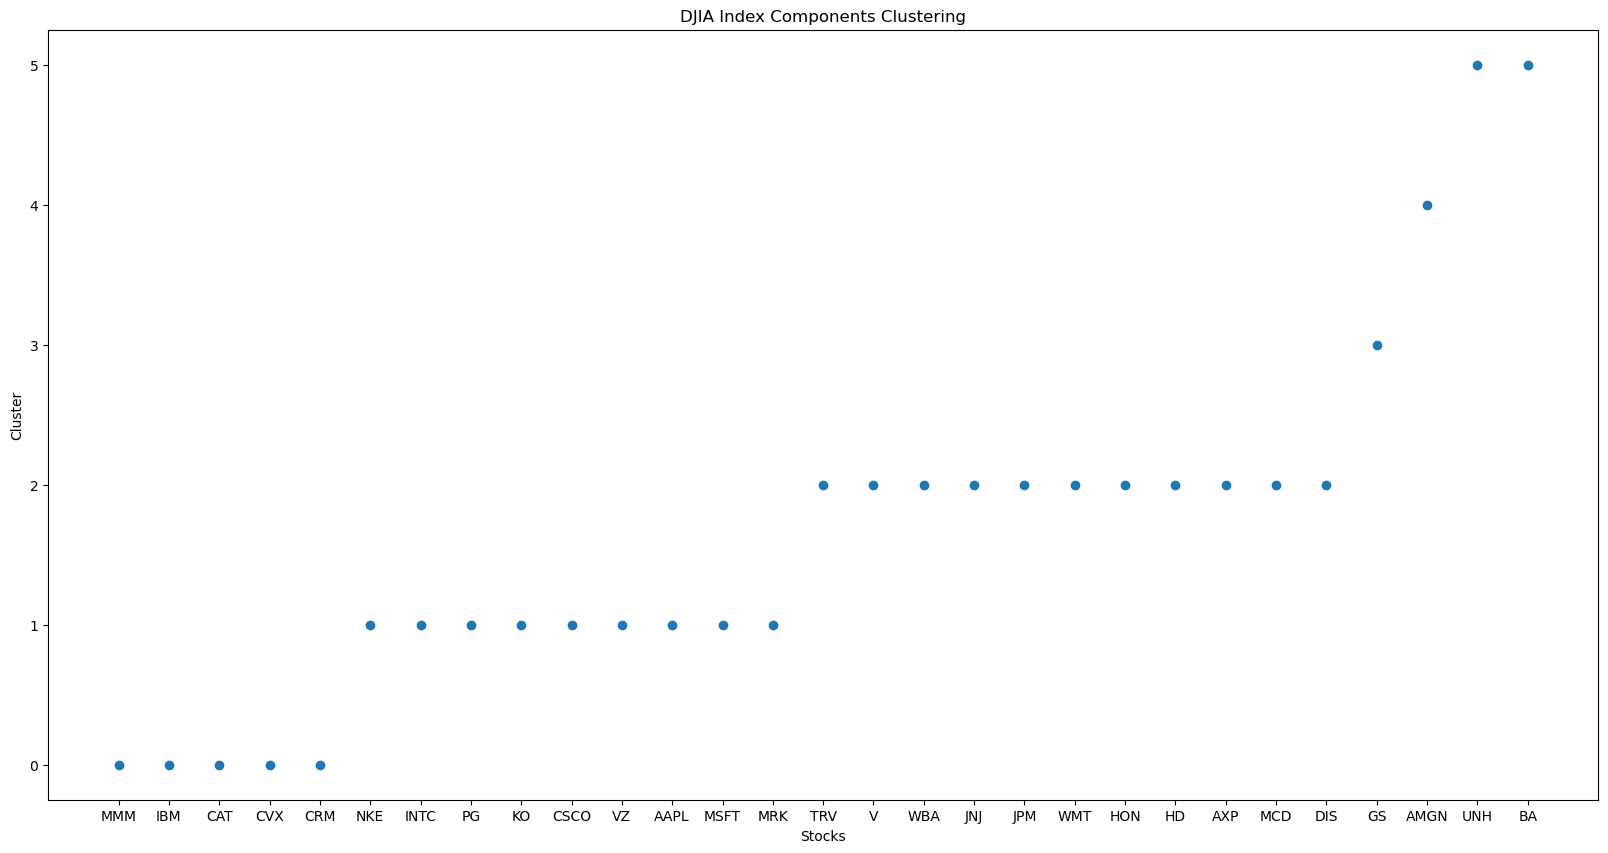

In [18]:
# Plot Clusters 
plt.figure(figsize=(20,10)) 
plt.scatter(df1.Companies, df1.Cluster) 
plt.xlabel('Stocks') 
plt.ylabel('Cluster') 
plt.title('DJIA Index Components Clustering');

### Portfolio Construction 

Shortlisting the six stocks from the above clusters (one for each), we will now build a portfolio and compare the returns with all stock portfolio.

In [19]:
# we choose those whoe are in the 0th class to build a portfolio
df1.loc[df1.Cluster==0,:]

,Cluster,Companies,ATR
0,0,MMM,2.101291
1,0,IBM,2.095919
2,0,CAT,2.079966
3,0,CVX,1.630457
4,0,CRM,2.199421


In [20]:
# Cluster portfolio stocks 

portfolio_stocks = df1.loc[df1.Cluster==0,'Companies'].values
port = pd.DataFrame({symbol: ohlc[symbol]['Close'] for symbol in portfolio_stocks}) 
port.dropna(inplace=True)

port

,MMM,IBM,CAT,CVX,CRM
Date,,,,,
2009-12-31,62.065166,92.406113,41.498463,50.924435,18.442499
2010-01-04,62.327927,93.500313,42.634403,52.293617,18.705000
2010-01-05,61.937550,92.370834,43.144135,52.664024,18.625000
2010-01-06,62.815929,91.770790,43.275200,52.670624,18.592501
2010-01-07,62.860950,91.453102,43.449959,52.472206,18.510000
...,...,...,...,...,...
2020-09-23,159.509995,118.830002,144.380005,71.949997,235.990005
2020-09-24,160.419998,118.089996,145.139999,71.800003,237.550003
2020-09-25,160.270004,118.949997,145.910004,71.830002,242.740005


In [21]:
# Calculate portfolio returns 
portfolio_returns = port.pct_change().fillna(0) 
port['Returns'] = portfolio_returns.mean(axis=1) 
# assuming equally weighted, so taking average for the returns of those stocks in that portfolio
port

,MMM,IBM,CAT,CVX,CRM,Returns
Date,,,,,,
2009-12-31,62.065166,92.406113,41.498463,50.924435,18.442499,0.000000
2010-01-04,62.327927,93.500313,42.634403,52.293617,18.705000,0.016914
2010-01-05,61.937550,92.370834,43.144135,52.664024,18.625000,-0.000716
2010-01-06,62.815929,91.770790,43.275200,52.670624,18.592501,0.001821
2010-01-07,62.860950,91.453102,43.449959,52.472206,18.510000,-0.001382
...,...,...,...,...,...,...
2020-09-23,159.509995,118.830002,144.380005,71.949997,235.990005,-0.029036
2020-09-24,160.419998,118.089996,145.139999,71.800003,237.550003,0.001853
2020-09-25,160.270004,118.949997,145.910004,71.830002,242.740005,0.006784


Start date,2009-12-31
End date,2020-09-29
Total months,128
,Backtest
Annual return,12.4%
Cumulative returns,252.4%
Annual volatility,21.0%
Sharpe ratio,0.66
Calmar ratio,0.35
Stability,0.93
Max drawdown,-35.7%


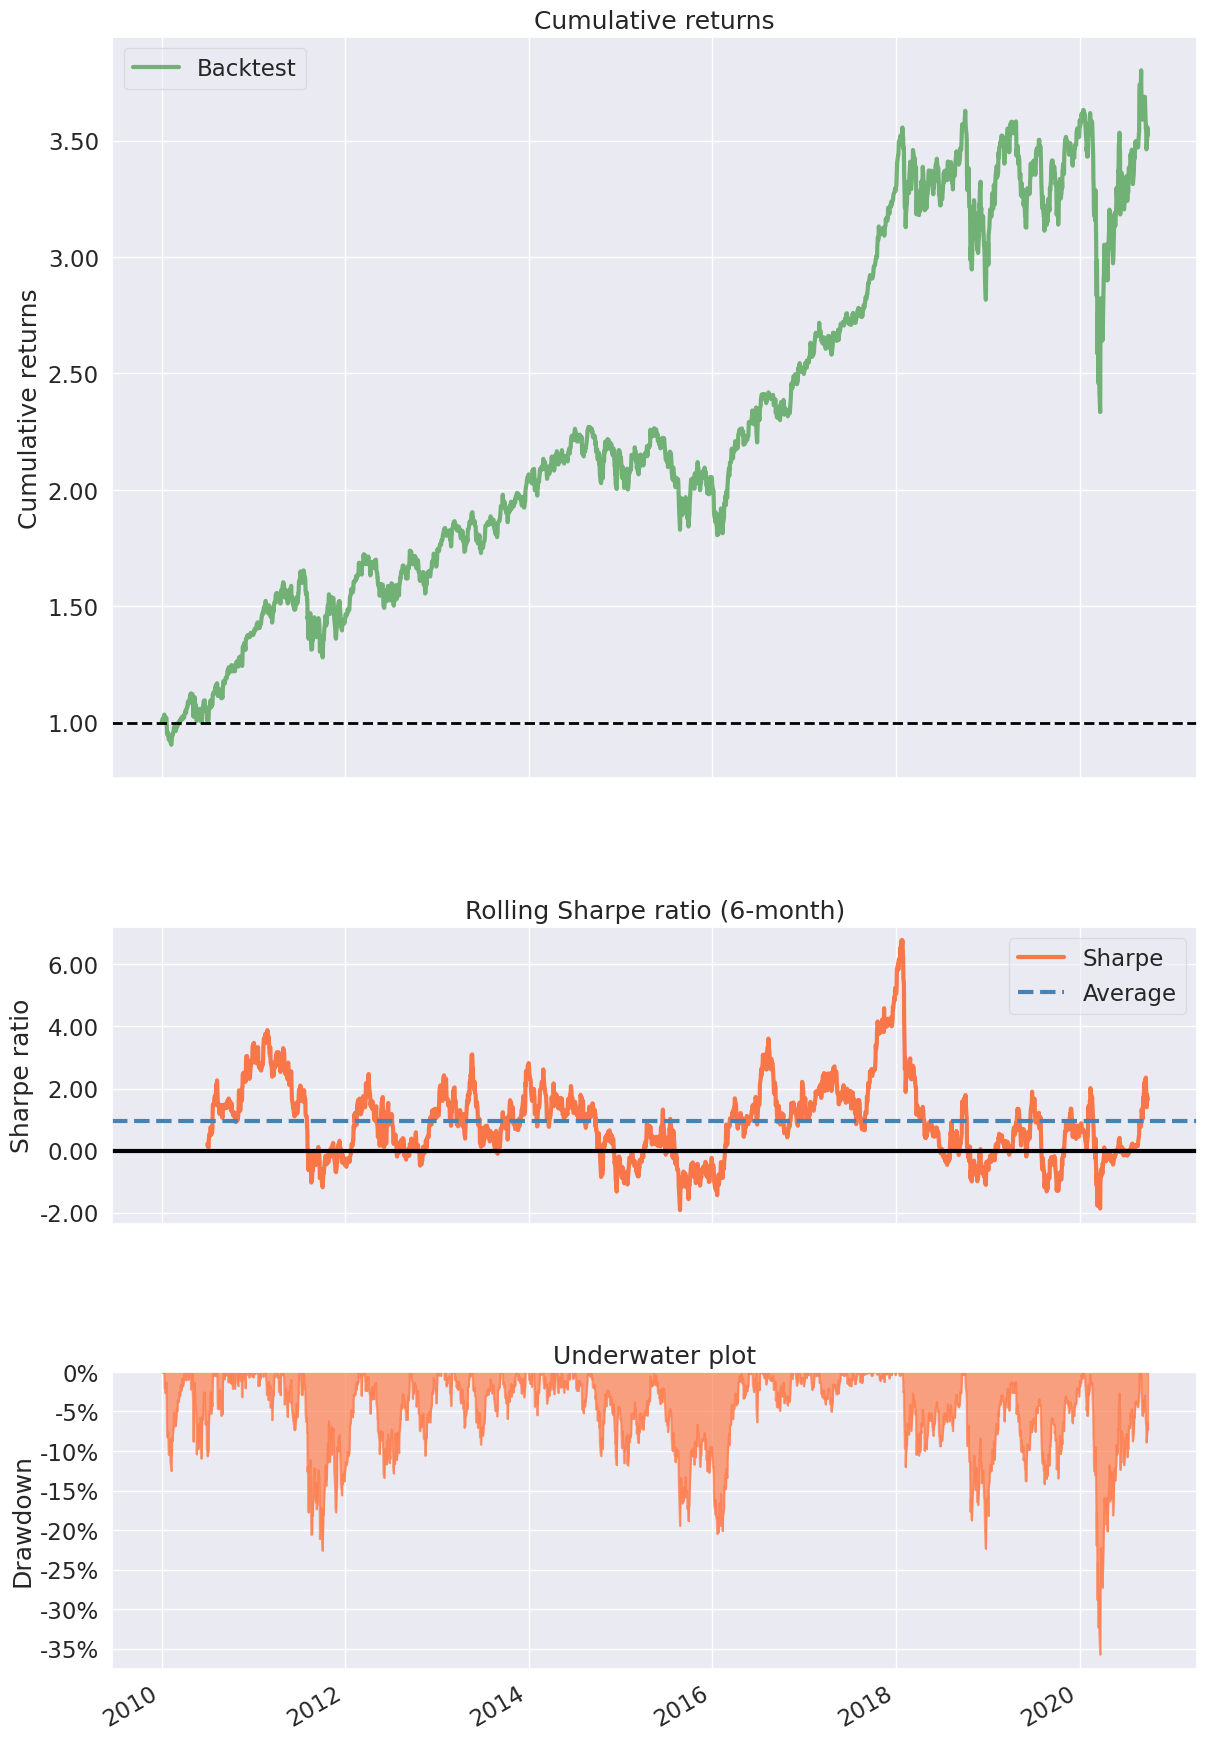

In [22]:
# Create Tear sheet using pyfolio 
pf.create_simple_tear_sheet(port['Returns'])

### In comparison with the all stock portfolio.

In [26]:
# All stocks portfolio 
all_stocks = pd.DataFrame({symbol: ohlc[symbol]['Close'] for symbol in companies}) 
all_stocks.dropna(inplace=True) 

# Calculate all stocks portfolio returns 
all_stocks_returns = all_stocks.pct_change().fillna(0) 
all_stocks['Returns'] = all_stocks_returns.mean(axis=1) 
all_stocks.head(2)

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS,Returns
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,62.065166,34.434761,45.404182,6.503574,41.856789,41.498463,50.924435,18.048286,18.951757,144.296997,...,43.431492,18.442499,38.205708,25.778193,18.633041,17.935587,28.350834,40.954620,28.090706,0.000000
2010-01-04,62.327927,34.774685,46.327202,6.604801,43.441975,42.634403,52.293617,18.613705,18.965061,147.920776,...,43.782478,18.705000,38.167397,26.666224,18.717409,18.075037,28.798639,41.552284,27.933924,0.013946


Start date,2009-12-31
End date,2020-09-29
Total months,128
,Backtest
Annual return,15.9%
Cumulative returns,385.9%
Annual volatility,17.2%
Sharpe ratio,0.94
Calmar ratio,0.48
Stability,0.98
Max drawdown,-33.1%


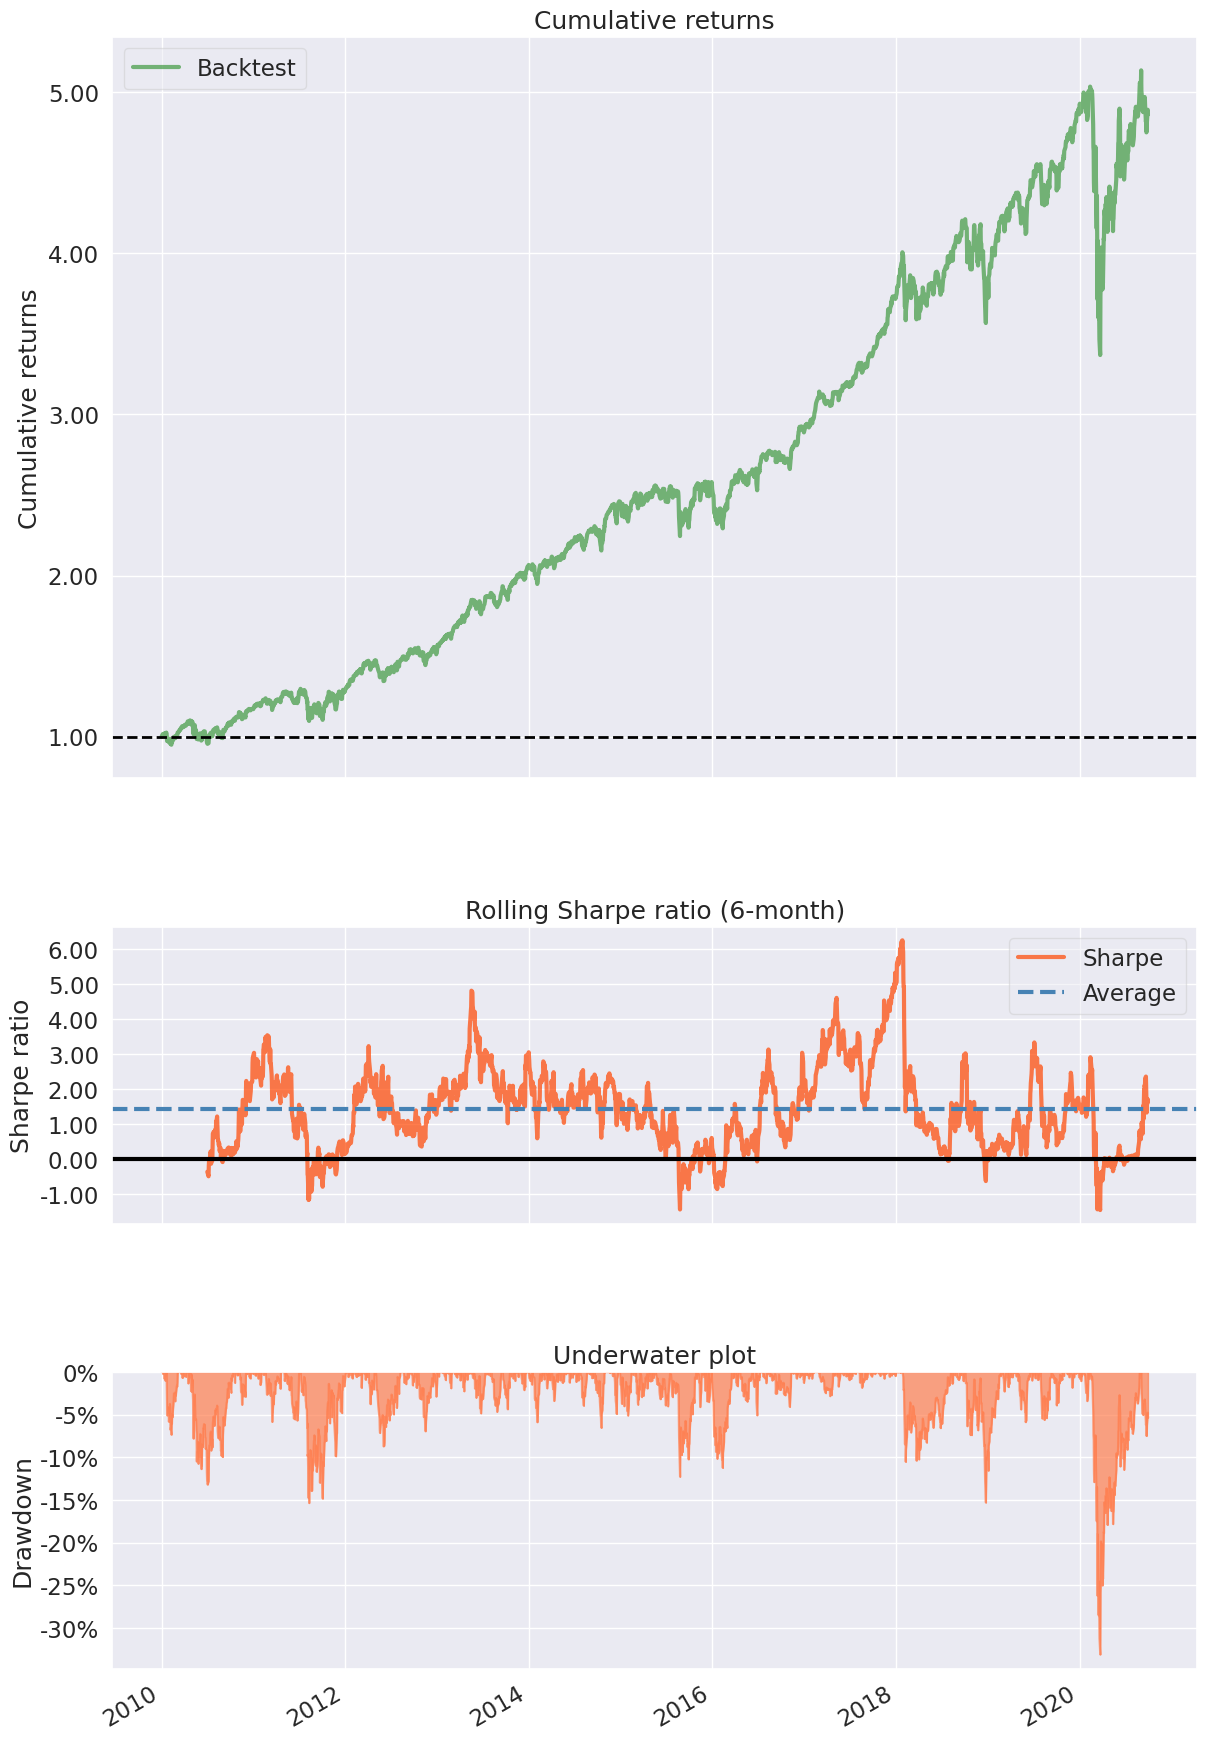

In [27]:
# Create Tear sheet using pyfolio 
pf.create_simple_tear_sheet(all_stocks['Returns']) 
plt.show()